In [14]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import rl_utils

In [15]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

In [16]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma, device):
        # 初始化策略网络 πθ(a|s)，输入状态维度、隐藏层、输出动作概率
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        # 使用 Adam 优化器来更新策略参数 θ
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)
        # 设置折扣因子 γ（用于计算累计奖励 Gt）
        self.gamma = gamma
        # 指定运行设备（CPU 或 GPU）
        self.device = device

    def take_action(self, state):
        # 将状态转换为张量并转移到设备上（形状为 [1, state_dim]）
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        # 前向传播获得动作的概率分布 πθ(a|s)
        probs = self.policy_net(state)
        # 构造一个离散分布 Categorical，并从中采样一个动作 a_t ~ πθ(·|s_t)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample() # sample()：从中随机抽取一个动作（用于执行）
        # 返回采样动作的索引（int）
        return action.item()

    def update(self, transition_dict):
        reward_list = transition_dict['rewards']  # 所有 t 时刻的 r_t
        state_list = transition_dict['states']    # 所有 t 时刻的 s_t
        action_list = transition_dict['actions']  # 所有 t 时刻的 a_t

        G = 0  # 初始化累计回报 G_t = r_t + γ·r_{t+1} + γ²·r_{t+2} + ...
        self.optimizer.zero_grad()  # 清除之前的梯度缓存

        # 从最后一个时间步开始反向遍历轨迹（反向计算 G_t）
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            
            # 当前状态 s_t 和动作 a_t 转为张量
            state = torch.tensor([state_list[i]], dtype=torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1, 1).to(self.device)

            # 获取当前策略下 πθ(a_t|s_t)，并取 log：log πθ(a_t|s_t)
            probs = self.policy_net(state)                      # πθ(·|s_t)
            log_prob = torch.log(probs.gather(1, action))       # 取对应 a_t 的 log 概率
            
            # 累计计算 G_t：G ← r_t + γ·G_{t+1}
            G = self.gamma * G + reward  # 即 G_t = r_t + γ·G_{t+1}

            # 损失函数为负的策略梯度目标：-G_t · log πθ(a_t | s_t)
            # 即 L = - ∑ G_t · log πθ(a_t | s_t)
            loss = -log_prob * G

            # 反向传播计算 ∇θ log πθ(a_t | s_t) 并累加每步的梯度
            loss.backward()

        # 所有步骤的梯度累计完毕后，统一进行参数更新：θ ← θ + α ∇θ J(θ)
        self.optimizer.step()

In [17]:
learning_rate = 1e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = "CartPole-v1"
env = gym.make(env_name)

# ✅ 设置环境随机种子，确保实验可复现（适配 Gym 0.26+ 新 API）
env.reset(seed=0)
env.action_space.seed(0)
env.observation_space.seed(0)

torch.manual_seed(0)

# ✅ 提取状态空间和动作空间维度（分别为观测向量维度和动作数量）
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# ✅ 初始化 REINFORCE 智能体
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []  # 用于记录每个 episode 的累计回报

# ✅ 将所有训练 episode 分为 10 个 iteration 分段输出（用于进度条）
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0  # 当前 episode 累计回报
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': []
            }
            state, _ = env.reset()  # ✅ 仅取出观测向量
            done = False

            # ✅ 执行一个完整 episode，直到 done
            while not done:
                action = agent.take_action(state)  # 按策略采样动作
                next_state, reward, terminated, truncated, _ = env.step(action)  # 与环境交互
                done = terminated or truncated
                # ✅ 存储转移数据
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward  # 累计 reward

            return_list.append(episode_return)  # ✅ 记录当前 episode 的总回报
            agent.update(transition_dict)       # ✅ 用当前 episode 更新策略参数

            # ✅ 每 10 个 episode 打印一次当前均值回报
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode': '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return': '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|██████████| 100/100 [00:04<00:00, 21.04it/s, episode=1000, return=466.200]


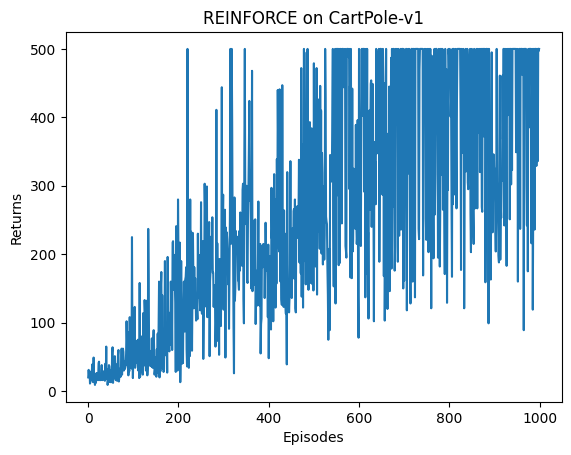

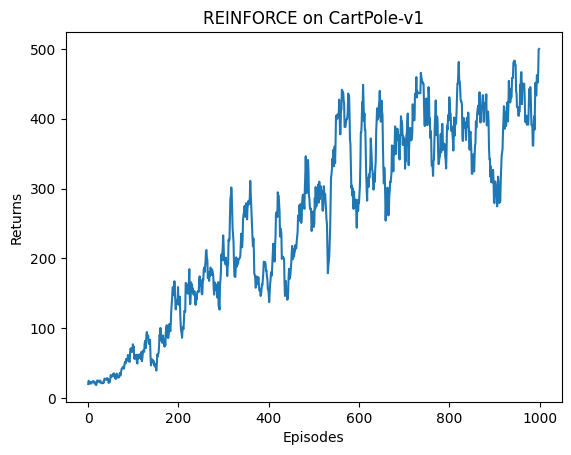

In [18]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()